In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from pysr import pysr, PySRRegressor
from tqdm import tqdm
import pandas as pd


In [101]:
cols0=np.array(['num_prog(0)', 'Mvir(1)', 'Rvir(2)', 'rs(3)', 'vrms(4)',
       'scale_of_last_MM(5)', 'vmax(6)', 'Jx(7)', 'Jy(8)',
       'Jz(9)', 'Tidal_Force((13)', 'Rs_Klypin(14)', 'Mvir_all(15)',
       'M200b(16)', 'M200c(17)', 'M500c(18)', 'M2500c(19)', 'Xoff(20)',
       'Voff(21)', 'Spin_Bullock(22)', 'b_to_a(23)', 'c_to_a(24)',
       'A[x](25)', 'A[y](26)', 'A[z](27)', 'b_to_a((28)',
       'c_to_a((29)', 'A[x]((30)', 'A[y]((31)', 'A[z]((32)',
       'T/|U|(33)', 'M_pe_Behroozi(34)', 'M_pe_Diemer(35)',
       'Halfmass_Radius(36)'])
cols = []

for i, c in enumerate(cols0):
    if c[-3]=='(':
        co = c[:-3]
    if c[-4]=='(':
        co = c[:-4]
    if co[-1]=='(':
        co=co[:-1]
    cols.append(co+f'({i})')
cols = np.array(cols)

In [3]:
print('Loading data')

xs = pickle.load(open(osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/standard_raw_final_6t/xs.pkl"), 'rb'))
ys = pickle.load(open(osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/standard_raw_final_6t/ys.pkl"), 'rb'))
n_feat = len(xs[0])
n_targ = len(ys[0])
print('Loaded data')

Loading data
Loaded data


In [4]:
fname = 'hall_of_fame_2022-05-09_204834.183.csv' 
fname = 'eqs_100522/crkzgl_Mstar.csv'
fname = 'eqs_100522/tkeref_Mstar.csv'
eqs = pd.read_csv(fname, delimiter = '|')
eqs['std'] = np.sqrt(eqs['MSE'])
eqs

,Complexity,MSE,Equation,std
0,1,0.896050,-1.1958371,0.946599
1,2,0.747699,log_abs(x0),0.864696
2,3,0.057915,(x16 + -1.2035097),0.240656
3,5,0.043809,((x16 + -1.3574468) / 1.128725),0.209306
4,7,0.033620,"((x16 - pow(1.1171565, x2)) - 0.19261244)",0.183357
5,8,0.033320,"(x16 - pow(exp(x2) + 2.605068, 0.12818456))",0.182537
6,9,0.033113,(x16 - sqrt_abs(sqrt_abs(sqrt_abs(exp(x2)) + 0...,0.181971
7,10,0.030402,"(x16 - pow(exp(x2) + (2.8137336 - x10), 0.1277...",0.174362
8,12,0.029668,"(x16 - pow((exp(x2) + (3.600346 - x10)) - x26,...",0.172243
9,14,0.029492,(x16 - pow((exp(x2) + (2.0568655 - x10)) + sqr...,0.171733


In [69]:
idx = 17
eq = eqs.iloc[idx]

In [70]:
module_dictionary = {'log': np.log10, 'abs': np.abs}
exec('''
def log_abs(x):
    return log(abs(x))
''', module_dictionary)
log_abs = module_dictionary['log_abs']

module_dictionary = {'sqrt': np.sqrt, 'abs': np.abs}
exec('''
def sqrt_abs(x):
    return sqrt(abs(x))
''', module_dictionary)
sqrt_abs = module_dictionary['sqrt_abs']

In [71]:
from sympy.parsing.sympy_parser import parse_expr
import sympy
from sympy import sympify, lambdify
streq = eq["Equation"]
print(streq)

(x16 - sqrt_abs(sqrt_abs(sqrt_abs((exp(x2) + ((log_abs((exp(x19) * -1.2638003) + log10_abs(x11)) - (x26 + -2.4575515)) - x3)) - x10))))


In [102]:
vs = []
for i, s in enumerate(streq):
    if s=='x' and streq[i+1].isdigit() and not streq[i+2].isdigit():
        vs.append(int(streq[i+1]))
    if s=='x' and streq[i+1].isdigit() and streq[i+2].isdigit():
        vs.append(int(streq[i+1:i+3]))
vs = np.array(vs)

In [103]:
vs, cols[vs]

(array([16,  2, 19, 11, 26,  3, 10]),
 array(['M2500c(16)', 'Rvir(2)', 'Spin_Bullock(19)', 'Rs_Klypin(11)',
        'c_to_a(26)', 'rs(3)', 'Tidal_Force(10)'], dtype='<U19'))

In [72]:
seq = parse_expr(eq["Equation"])
class CallableEquation:
    """Simple wrapper for numpy lambda functions built with sympy"""

    def __init__(self, sympy_symbols, eqn, selection=None, variable_names=None):
        self._sympy = eqn
        self._sympy_symbols = sympy_symbols
        self._selection = selection
        self._variable_names = variable_names
        self._lambda = lambdify(sympy_symbols, eqn, ['numpy', {'log_abs':log_abs, 'sqrt_abs':sqrt_abs}])

    def __repr__(self):
        return f"PySRFunction(X=>{self._sympy})"

    def __call__(self, X):
        expected_shape = (X.shape[0],)
        if isinstance(X, pd.DataFrame):
            # Lambda function takes as argument:
            return self._lambda(**{k: X[k].values for k in X.columns}) * np.ones(
                expected_shape
            )
        elif self._selection is not None:
            return self._lambda(*X[:, self._selection].T) * np.ones(expected_shape)
        return self._lambda(*X.T) * np.ones(expected_shape)

In [73]:
all_outputs = [pd.read_csv(fname, sep = "|")]
all_outputs[-1].rename(
    columns={
        "Complexity": "complexity",
        "MSE": "loss",
        "Equation": "equation",
    },
    inplace=True    
)
    
ret_outputs = []

for output in all_outputs:
    scores = []
    lastMSE = None
    lastComplexity = 0
    sympy_format = []
    lambda_format = []

    sympy_symbols = [sympy.Symbol("x%d" % i) for i in range(n_feat)]

    for _, eqn_row in output.iterrows():
        eqn = eqn_row["equation"]
#         eqn.replace('sqrt_', 'sqrt()')
#         print(eqn)
        eqn = sympify(eqn)
        sympy_format.append(eqn)

        # Numpy:
        lambda_format.append(
            CallableEquation(
                sympy_symbols, eqn))


In [74]:
idx =10
leq = lambda_format[idx]
# print(sympy_format[idx], idx), leq.__call__.__globals__

In [75]:
log_abs(100)

2.0

['M2500c(16)',
 'Rvir(2)',
 'Spin_Bullock(19)',
 'Rs_Klypin(11)',
 'c_to_a(26)',
 'rs(3)',
 'Tidal_Force(10)']

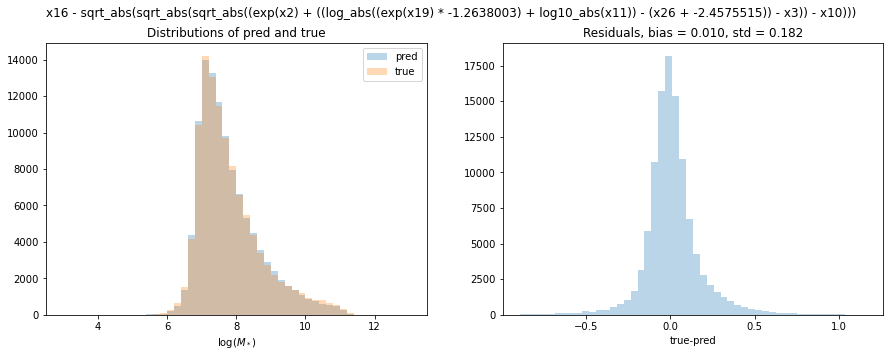

In [108]:
#check distributions
mstar_pred = leq(xs)+9
mstar_ys = ys[:,0]+9

l=0.01
tot = np.hstack([mstar_pred, mstar_ys])
r = np.nanpercentile(tot, [l, 100-l])
r = [3,13]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

ax[0].hist(mstar_pred, bins=50, alpha=0.3, range=r, label='pred');
ax[0].hist(mstar_ys, bins=50, alpha=0.3, range=r, label='true');
ax[0].set(title = f'Distributions of pred and true', xlabel=r'log($M_*$)')
ax[0].legend()

##
res = mstar_ys - mstar_pred

ax[1].hist(res, bins=50, alpha=0.3, range=np.nanpercentile(res, [l*10,100-l*10]));
ax[1].set(title = f'Residuals, bias = {np.nanmean(res):.3f}, std = {np.nanstd(res):.3f}', xlabel = 'true-pred')
fig.suptitle(streq[1:-1]);
list(cols[vs])

array(['M2500c(16)', 'Rvir(2)', 'Spin_Bullock(19)', 'Rs_Klypin(11)',
       'c_to_a(26)', 'rs(3)', 'Tidal_Force(10)'], dtype='<U19')

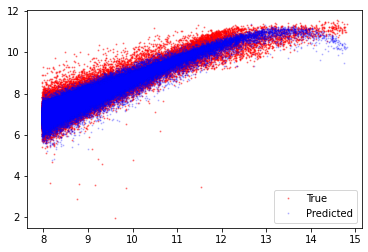

In [77]:
#check M_halo
Mh = xs[:,1]+9 #standard scaled so not quite the usual
plt.plot(Mh, mstar_ys, 'ro', ms=1, alpha=0.4, label='True');
plt.plot(Mh, mstar_pred, 'bo', ms=1, alpha=0.2,label='Predicted');
plt.legend()

In [12]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats
import matplotlib as mpl
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot(ys, pred):
    fig, ax = plt.subplots(figsize=(8, 6))
#     ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
    targets = [r"$M_{*}$"]
    for i in range(1):
        target=targets[i]
        ys = ys
        pred = pred
        nullfmt = NullFormatter()         # no labels
        # definitions for the axes
        left, width = 0.1, 0.67
        bottom, height = 0.0, 0.75
        bottom_h = bottom +height
        left_h = left + width
        # rect_Cbar = [0, bottom, 0.1, height]
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.15]
        rect_histy = [left_h, bottom, 0.15+0.01, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

        # start with a rectangular Figure
        ax.set_axis_off()
        # axCbar = plt.axes(rect_Cbar)
        axHist = ax.inset_axes(rect_scatter)
        axHistx = ax.inset_axes(rect_histx)
        axHisty = ax.inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)

        bins=50
        l=0.005
        n_contour=4
        # the scatter plot:
        vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                    np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white', linestyles='dashed', linewidths=1.2)
        axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
        if i==0:
            axHist.set(xlabel=f'SAM {target}',ylabel=f'GNN {target}', xticks=[5,6,7,8,9,10,11])
        else:
            axHist.set(xlabel=f'SAM {target}',ylabel=f'Abundance matched {target}', xticks=[5,6,7,8,9,10,11])
        if i==0:
            axHist.legend(loc='lower right', fontsize=14)
            

        X, Y = X[0], Y.T[0]
        axHist.set_xlim((min(X), max(X)))
        axHist.set_ylim((min(Y), max(Y)))
        yhat=r'$\hat{y}$'

        #calculate metrics
        pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
        r2=r2_score(ys,pred)
        rho = np.corrcoef(ys,pred)[0,1]
        print(np.std(ys-pred),np.mean(ys-pred), pct, r2, rho)

        xt=0.03
        yt=0.85
        dy=0.07
        font = {'weight': 'normal',
            'size': 15}

        axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


        # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
        # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
        ys_kde = stats.gaussian_kde(ys, 0.1)
        pred_kde = stats.gaussian_kde(pred, 0.1)
        axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
        axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
        axHistx.legend(loc='upper left',fontsize=12)
        axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.125), fontsize=12)

        axHistx.set(title=f'PySR {target} relationship')

#         axHistx.set_xlim(axHist.get_xlim())
#         axHisty.set_ylim(axHist.get_ylim())

        divider = make_axes_locatable(axHisty)
        cax = divider.append_axes("right", size="5%", pad=0.0)
        divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

        # Plot vertical colorbar
        plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

0.19399145805678755 -0.010319825178635535 0.8387185860259597 0.9563788192057945 0.97815592056905


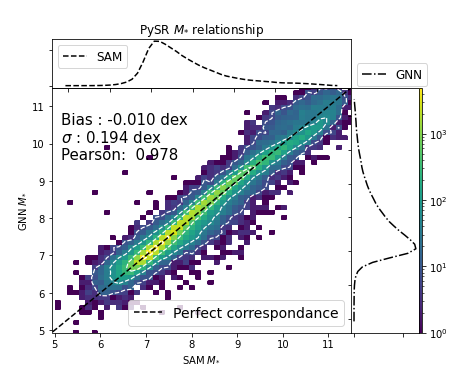

In [13]:
fig = plot(mstar_ys, mstar_pred)